In [3]:
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import numpy as np

In [94]:
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno

In [4]:
path = '../.outputs/data_model_xy.geojson'
df_p = gpd.read_file(path)

<Axes: >

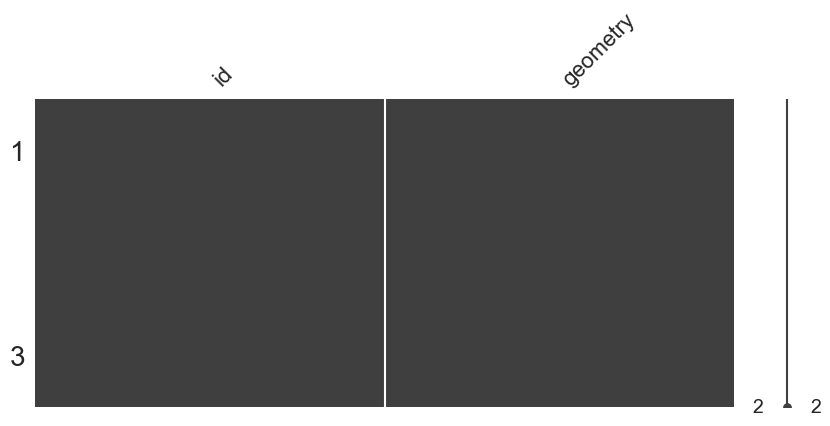

In [5]:
msno.matrix(df_p, figsize=(10,4)) # test pustych wierszy
# df_p =df_p.fillna(0) # wypełnianie Nan zerami


In [6]:
df_p.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,3.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [7]:
df_p.explode(ignore_index=True)

,id,geometry
0,1,"LINESTRING (661651.040 563319.409, 661652.571 ..."
1,1,"LINESTRING (662144.578 562932.642, 662143.396 ..."
2,1,"LINESTRING (662131.992 562825.761, 662132.398 ..."


In [8]:
df_p.shape

(3, 2)

In [9]:
#normalizacja i podzial na dane wejsciowe i wyjsciowe
X = df_p.get_coordinates()[["x"]]
X = MinMaxScaler().fit_transform(X)
y = df_p.get_coordinates()[["y"]]
X.shape, y.shape

((1298, 1), (1298, 1))

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     # random_state=42,
                                                     test_size=.2)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1038, 1), (260, 1), (1038, 1), (260, 1))

# MODEL

In [12]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate,Dropout,CategoryEncoding, Embedding, Flatten,Conv2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.random import set_seed #ustawiam ziarno pseudolosowości
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime as dt
import os

In [13]:
N_TRAIN = int(1e4)
BATCH_SIZE = 8
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0001,
  decay_steps=STEPS_PER_EPOCH*1,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.experimental.RMSprop(lr_schedule)

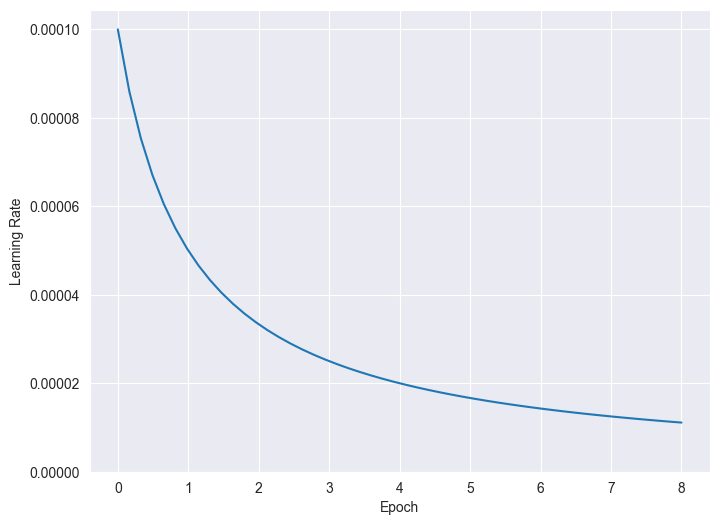

In [14]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [15]:
from keras import regularizers


def create_ANN():
    set_seed(0)
    model = Sequential()
    model.add(
        Dense(1, activation='relu',
              kernel_regularizer=regularizers.l2(0.01), #opcja
              kernel_initializer='he_uniform')
    )
    model.add(Dense(2,activation='relu'))
    model.add(
        Dense(1, activation='relu',
              kernel_regularizer=regularizers.l2(0.01))# opcja
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredLogarithmicError(),
        optimizer=get_optimizer(),
        metrics=['accuracy'])

    return model

In [16]:
_filepath = '../.outputs/checkpoint/ann-{epoch:02d}-{loss:.3f}.h5' # for filepath
checkpoint = ModelCheckpoint(monitor='loss', filepath='../.outputs/checkpoint/_best-ann.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='loss', patience=3, min_delta=0.01, verbose=1)
tb = TensorBoard(log_dir='logs/'+dt.now().strftime("%Y%m%d-%H%M%S")) # logi tensor board

In [17]:
model = create_ANN()

result = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    validation_split=.3,
    callbacks=[checkpoint, tb],
    verbose=0,
)





Epoch 1: loss improved from inf to 175.38635, saving model to ../.outputs/checkpoint\_best-ann.h5


D:\OneDrive - Wojskowa Akademia Techniczna\Pulpit\mormus\ai_river_project\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 175.38635 to 175.38576, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 3: loss improved from 175.38576 to 175.38521, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 4: loss improved from 175.38521 to 175.38470, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 5: loss improved from 175.38470 to 175.38417, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 6: loss improved from 175.38417 to 175.38376, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 7: loss improved from 175.38376 to 175.38326, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 8: loss improved from 175.38326 to 175.38290, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 9: loss improved from 175.38290 to 175.38249, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 10: loss improved from 175.38249 to 175.38210, saving model to ../.outputs/checkpoint\_best-ann.h5

Epoch 11: loss improved from 175.38210 to 175.38173, 

In [131]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 1)                 2         
                                                                 
 dense_39 (Dense)            (None, 2)                 4         
                                                                 
 dense_40 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [102]:
# evaluate the keras model
loss,  mae , mse = model.evaluate(X_test, y_test)
print(f'loss:{loss}, \nmse: {mse}')

9/9 [==============================] - 0s 2ms/step - loss: 175.3392 - mae: 563053.5000 - mse: 317029285888.0000
loss:175.33920288085938, 
mse: 317029285888.0


Text(0.5, 0, 'Epoka')

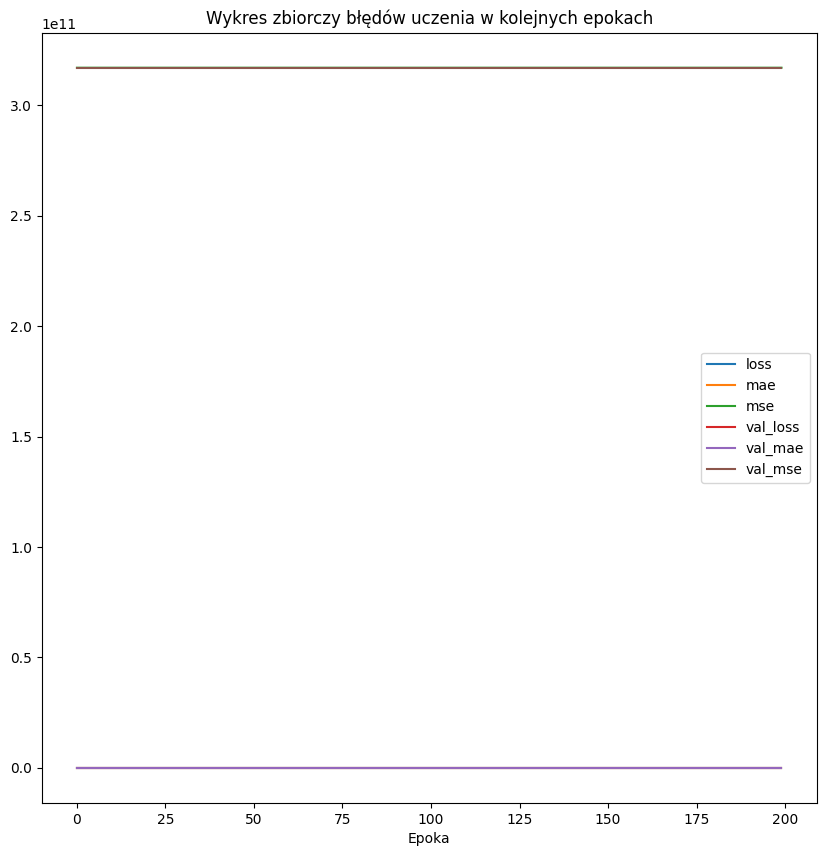

In [103]:
df_results = pd.DataFrame(result.history)
df_results.plot(figsize=(10,10))
plt.title('Wykres zbiorczy błędów uczenia w kolejnych epokach')
plt.xlabel('Epoka')

In [104]:
df_results

,loss,mae,mse,val_loss,val_mae,val_mse
0,175.374100,563068.0625,3.170460e+11,175.372559,563048.125,3.170232e+11
1,175.372971,563068.1250,3.170459e+11,175.371414,563048.125,3.170232e+11
2,175.371765,563068.3125,3.170460e+11,175.370361,563048.125,3.170232e+11
3,175.370834,563068.3125,3.170459e+11,175.369385,563048.125,3.170232e+11
4,175.369858,563068.2500,3.170460e+11,175.368469,563048.125,3.170232e+11
...,...,...,...,...,...,...
195,175.340042,563068.3125,3.170459e+11,175.339111,563048.125,3.170232e+11
196,175.340012,563068.3750,3.170459e+11,175.339035,563048.125,3.170232e+11
197,175.339966,563068.3750,3.170460e+11,175.339020,563048.125,3.170232e+11
198,175.339981,563068.3750,3.170459e+11,175.338974,563048.125,3.170232e+11


In [105]:
y_predicted = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [106]:
df__a = pd.DataFrame(y_test)
df__a['y_predicted']=y_predicted
df__a['diff']=df__a.y_predicted-df__a.distance
df__a['abs_diff'] = abs(df__a['diff'])
df__a['diff_pow']=df__a['diff']*df__a['diff']
df__a.tail()

AttributeError: 'DataFrame' object has no attribute 'distance'

In [107]:
import math
mean_ref = df__a['distance'].describe()[1]
bias = df__a['diff'].describe()[1]
mae =df__a['abs_diff'].describe()[1]
RMSE = math.sqrt(df__a['diff_pow'].sum()/df__a.shape[0])
print(
    f'mean_ref: {mean_ref},'
    f'\nbias: {bias}, \nbias_%: {bias/mean_ref*100}, '
    f'\nmae: {mae}, \nmae_%: {mae/mean_ref*100}, '
    f'\nRMSE: {RMSE} \nRMSE %: {RMSE/mean_ref*100}'
)

KeyError: 'distance'

In [108]:
# rozkład błedów
error = df__a.y_predicted-df__a.distance
plt.figure(figsize = (6,6))
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

AttributeError: 'DataFrame' object has no attribute 'distance'

KeyError: 'distance'

<Figure size 800x800 with 0 Axes>

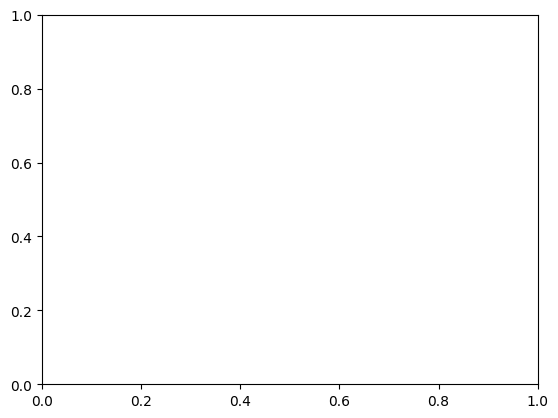

In [167]:
plt.figure(figsize = (8,8))
df__a.plot.scatter(y='y_predicted', x='distance')
plt.plot(range(5), color='orange')
plt.xlim(50, 350)
plt.ylim(100, 250)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('y_ref')
plt.ylabel('y_pred')
plt.draw()

In [ ]:
# print(y_predicted)

In [110]:

# df__a = pd.merge(df__a, df_p[['ID', 'angle']], left_index=True, right_index=True)
# print(df__a)


In [1]:
# df__a.to_csv(path_or_buf="./results.csv",index=False,quoting=3,sep=';')



4/4 [==============================] - 0s 5ms/step


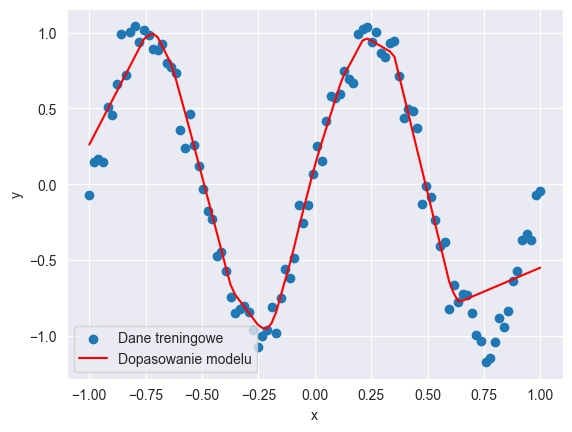

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Tworzenie danych x i y, przy założeniu zależności wielomianowej 10. stopnia
x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = np.sin(2 * np.pi * x_train) + np.random.normal(0, 0.1, size=x_train.shape)

# Definicja modelu sieci neuronowej z wielomianem 10. stopnia
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(1,), activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='mse')

# Trenowanie modelu
model.fit(x_train, y_train, epochs=1000, verbose=0)

# Przewidywanie wartości y dla danych x
x_test = np.linspace(-1, 1, 100)[:, np.newaxis]
y_pred = model.predict(x_test)

# Wyświetlenie danych i dopasowania modelu
plt.scatter(x_train, y_train, label='Dane treningowe')
plt.plot(x_test, y_pred, 'r-', label='Dopasowanie modelu')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [28]:
df_p.geometry.get_coordinates().x[0].dropna()

0    661651.040108
0    661652.571296
0    661653.451200
0    661653.980606
0    661654.375077
         ...      
0    662126.823064
0    662127.821638
0    662129.519327
0    662131.007094
0    662131.991669
Name: x, Length: 1026, dtype: float64

33/33 [==============================] - 0s 2ms/step


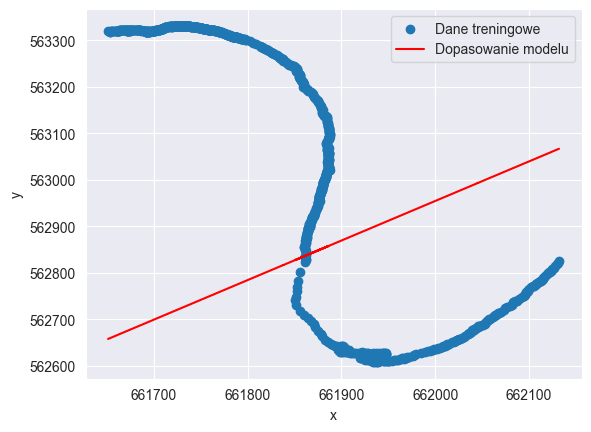

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Tworzenie danych x i y, przy założeniu zależności wielomianowej 10. stopnia
x_train = df_p.geometry.get_coordinates().x[0].dropna()
y_train = df_p.geometry.get_coordinates().y[0].dropna()

# Definicja modelu sieci neuronowej z wielomianem 10. stopnia
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(1,), activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='mse')

# Trenowanie modelu
model.fit(x_train, y_train, epochs=1000, verbose=0)

# Przewidywanie wartości y dla danych x
x_test = x_train
y_pred = model.predict(x_test)

# Wyświetlenie danych i dopasowania modelu
plt.scatter(x_train, y_train, label='Dane treningowe')
plt.plot(x_test, y_pred, 'r-', label='Dopasowanie modelu')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()